In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import copy
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print(DEVICE)

cuda


In [3]:
train_df = pd.read_csv("./normalized_train.csv")

train_df_typeA = train_df[train_df["PRODUCT_CODE"] == 0]
train_df_typeTO = train_df[train_df["PRODUCT_CODE"] != 0]

train_df_typeA =train_df.drop(columns=["LINE"])
train_df_typeTO =train_df.drop(columns=["LINE"])

train_typeA_tensor = torch.tensor(train_df_typeA.values).float()
train_typeTO_tensor = torch.tensor(train_df_typeTO.values).float()

test_df = pd.read_csv("./normalized_test.csv")
test_df = test_df.drop(columns=["LINE"])
test_tensor = torch.tensor(test_df.values).float()

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, index):
        x = self.data[index][1:]
        y = self.data[index][0].long()
        return x, y
    
    def __len__(self):
        return len(self.data)

In [5]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, index):
        x = self.data[index]
        return x
    
    def __len__(self):
        return len(self.data)

In [6]:
train_typeA_dataset = CustomDataset(train_typeA_tensor)
train_typeA_loader = DataLoader(train_typeA_dataset, batch_size=16, shuffle=True)

train_typeTO_dataset = CustomDataset(train_typeA_tensor)
train_typeTO_loader = DataLoader(train_typeTO_dataset, batch_size=16, shuffle=True)

test_dataset = TestDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [7]:
for x,y in train_typeA_loader:
    print(x.shape)
    print(y.shape)
    break;

torch.Size([16, 2876])
torch.Size([16])


In [8]:
class MLP_typeA(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLP_typeA, self).__init__()
        self.in_channels = in_channels
        self.layer1 = nn.Linear(in_channels, 512)
        self.layer2 = nn.Linear(512, 64)
        self.layer3 = nn.Linear(64, 3)
        
        self.dropout_prob = 0.2
        
    def forward(self, x):
        x = x.view(-1, self.in_channels)
        x = self.layer1(x)
        x = F.dropout(x, training=self.training,p=self.dropout_prob)
        x = F.selu(x)
        x = self.layer2(x)
        x = F.dropout(x, training=self.training,p=self.dropout_prob)
        x = F.selu(x)
        x = self.layer3(x)
        x = F.log_softmax(x,dim=1)
        return x
    
class MLP_typeTO(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLP_typeTO, self).__init__()
        self.in_channels = in_channels
        self.layer1 = nn.Linear(in_channels, 512)
        self.layer2 = nn.Linear(512, 32)
        self.layer3 = nn.Linear(32, 3)
        
        self.dropout_prob = 0.2
    
    def forward(self, x):
        x = x.view(-1, self.in_channels)
        x = self.layer1(x)
        x = F.dropout(x, training=self.training,p=self.dropout_prob)
        x = F.selu(x)
        x = self.layer2(x)
        x = F.dropout(x, training=self.training,p=self.dropout_prob)
        x = F.selu(x)
        x = self.layer3(x)
        x = F.log_softmax(x,dim=1)
        return x    

In [9]:
# 클래스 가중치 계산
class_weights = [1.0,4.0,1.1] # 모든 클래스에 대해 1.0으로 초기화
class_weights = torch.FloatTensor(class_weights)

In [10]:
model_typeA = MLP_typeA(2876,3).to(DEVICE)
loss_func = nn.CrossEntropyLoss(weight=class_weights).to(DEVICE)
optimizer = optim.Adam(model_typeA.parameters(), lr=0.001, weight_decay=0)

In [11]:
def train(model, train_dataset):
    model.train()
    for data,target in train_dataset:
        optimizer.zero_grad()
        
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        
        output = model(data).to(DEVICE)
        loss = loss_func(output, target)
        loss.backward()
        
        optimizer.step()

In [12]:
def evaluate(model, loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            output = model(data)
            test_loss += loss_func(output, target).item()
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(loader.dataset)
    test_accuracy = 100. * correct / len(loader.dataset)
    return test_loss, test_accuracy

In [13]:
typeA_loss_list = []
typeA_best_acc = 0.0  
typeA_best_model_wts = copy.deepcopy(model_typeA.state_dict()) 

for epoch in range(30):
    train(model_typeA, train_typeA_loader)
    
    train_loss, train_acc = evaluate(model_typeA,train_typeA_loader)
    typeA_loss_list.append(train_loss)    
    
    if train_acc >= typeA_best_acc: 
            typeA_best_acc = train_acc 
            typeA_best_model_wts = copy.deepcopy(model_typeA.state_dict())
    
    print('EPOCH[{:d}] - train Loss: {:.4f}, Accuracy: {:.4f}%'.format(epoch, train_loss, train_acc)) 
    
model_typeA.load_state_dict(typeA_best_model_wts)

EPOCH[0] - train Loss: 0.0221, Accuracy: 73.7458%
EPOCH[1] - train Loss: 0.0180, Accuracy: 76.2542%
EPOCH[2] - train Loss: 0.0129, Accuracy: 81.9398%
EPOCH[3] - train Loss: 0.0120, Accuracy: 87.2910%
EPOCH[4] - train Loss: 0.0087, Accuracy: 88.9632%
EPOCH[5] - train Loss: 0.0081, Accuracy: 89.2977%
EPOCH[6] - train Loss: 0.0082, Accuracy: 89.9666%
EPOCH[7] - train Loss: 0.0059, Accuracy: 91.9732%
EPOCH[8] - train Loss: 0.0169, Accuracy: 86.7893%
EPOCH[9] - train Loss: 0.0054, Accuracy: 92.4749%
EPOCH[10] - train Loss: 0.0054, Accuracy: 92.9766%
EPOCH[11] - train Loss: 0.0028, Accuracy: 95.8194%
EPOCH[12] - train Loss: 0.0023, Accuracy: 96.4883%
EPOCH[13] - train Loss: 0.0035, Accuracy: 96.9900%
EPOCH[14] - train Loss: 0.0020, Accuracy: 97.6589%
EPOCH[15] - train Loss: 0.0013, Accuracy: 98.4950%
EPOCH[16] - train Loss: 0.0075, Accuracy: 94.6488%
EPOCH[17] - train Loss: 0.0103, Accuracy: 91.8060%
EPOCH[18] - train Loss: 0.0020, Accuracy: 96.6555%
EPOCH[19] - train Loss: 0.0029, Accuracy:

<All keys matched successfully>

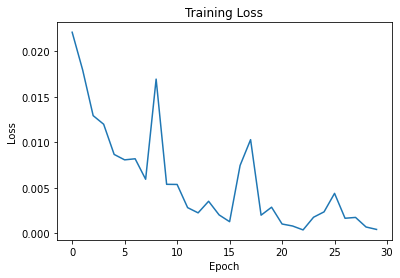

In [14]:
plt.plot(typeA_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [15]:
model_typeTO = MLP_typeTO(2876,3).to(DEVICE)
loss_func = nn.CrossEntropyLoss(weight=class_weights).to(DEVICE)
optimizer = optim.Adam(model_typeTO.parameters(), lr=0.001,weight_decay=0)

In [16]:
typeTO_loss_list = []
typeTO_best_acc = 0.0  
typeTO_best_model_wts = copy.deepcopy(model_typeTO.state_dict()) 

for epoch in range(30):
    train(model_typeTO, train_typeTO_loader)
    
    train_loss, train_acc = evaluate(model_typeTO,train_typeTO_loader)
    typeTO_loss_list.append(train_loss)    
    
    if train_acc >= typeTO_best_acc: 
            typeTO_best_acc = train_acc 
            typeTO_best_model_wts = copy.deepcopy(model_typeTO.state_dict())
    
    print('EPOCH[{:d}] - train Loss: {:.4f}, Accuracy: {:.4f}%'.format(epoch, train_loss, train_acc)) 
    
model_typeTO.load_state_dict(typeTO_best_model_wts)

EPOCH[0] - train Loss: 0.0253, Accuracy: 72.0736%
EPOCH[1] - train Loss: 0.0187, Accuracy: 77.2575%
EPOCH[2] - train Loss: 0.0150, Accuracy: 81.6054%
EPOCH[3] - train Loss: 0.0143, Accuracy: 79.7659%
EPOCH[4] - train Loss: 0.0103, Accuracy: 84.2809%
EPOCH[5] - train Loss: 0.0079, Accuracy: 89.1304%
EPOCH[6] - train Loss: 0.0085, Accuracy: 89.7993%
EPOCH[7] - train Loss: 0.0049, Accuracy: 92.6421%
EPOCH[8] - train Loss: 0.0050, Accuracy: 94.1472%
EPOCH[9] - train Loss: 0.0064, Accuracy: 92.6421%
EPOCH[10] - train Loss: 0.0045, Accuracy: 93.3110%
EPOCH[11] - train Loss: 0.0020, Accuracy: 96.4883%
EPOCH[12] - train Loss: 0.0066, Accuracy: 92.4749%
EPOCH[13] - train Loss: 0.0041, Accuracy: 93.9799%
EPOCH[14] - train Loss: 0.0030, Accuracy: 95.4849%
EPOCH[15] - train Loss: 0.0055, Accuracy: 94.4816%
EPOCH[16] - train Loss: 0.0015, Accuracy: 97.8261%
EPOCH[17] - train Loss: 0.0080, Accuracy: 91.6388%
EPOCH[18] - train Loss: 0.0044, Accuracy: 94.1472%
EPOCH[19] - train Loss: 0.0015, Accuracy:

<All keys matched successfully>

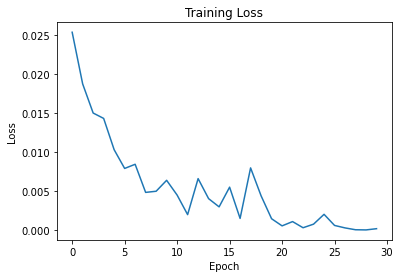

In [17]:
plt.plot(typeTO_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [18]:
predictions = []
for data in test_loader:
    data = data.to(DEVICE)
    product_code = data[:, 0]
    if product_code == 0:
        output = model_typeA(data)
        #print("model_A")
    else:
        output = model_typeTO(data)
        #print("model_TO")
    
    pred = torch.exp(output)
    _, pred = pred.topk(1, dim=1)
    predictions.append(pred.item())
        
    

In [19]:
print(predictions)
print(len(predictions))
print("class_0: " , predictions.count(0))
print("class_1: " , predictions.count(1))
print("class_2: " , predictions.count(2))

[1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 1, 0, 0, 0, 1, 2, 2, 0, 1, 1, 2, 0, 1, 0, 0, 0, 2, 1, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 0, 1, 2, 1, 1, 2, 2, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1]
310
class_0:  49
class_1:  210
class_2:  51


In [20]:
submit = pd.read_csv('./sample_submission.csv')
submit['Y_Class'] = predictions
submit.to_csv('layer3(512,32)_w(1_4_1.1)_drop(0.2)_selu(49,210,51).csv', index=False)